In [3]:
import json
import pandas as pd
import hvplot.pandas
import requests
import numpy as np
from config import openweather_key
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


sales_data_path = "/Users/larry/OneDrive/Desktop/LJ_Project_1/Project_1/file.csv"


sales_data = pd.read_csv(sales_data_path)

sales_data.head()


,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
1,1,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
2,2,17850.0,M,Chicago,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,...,122.77,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
3,3,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,...,81.50,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
4,4,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0


In [2]:
import warnings

In [4]:

#dropping redundant and un-needed columns
sales_data_cleaned = sales_data.drop(['Unnamed: 0', 'Tenure_Months', 'Transaction_Date', 'GST', 'Offline_Spend', 'Online_Spend', 'Month', 'Coupon_Code', 'Discount_pct', 'Product_SKU'], axis=1)


#dropping rows that have incomplete data
sales_data_cleaned = sales_data_cleaned.dropna()


#converting the date to unix time format for the api request & and adding it to a column
sales_data_cleaned['Date'] = pd.to_datetime(sales_data_cleaned['Date'])

sales_data_cleaned["Unix Date"] = sales_data_cleaned['Date'].apply(lambda x: int(x.timestamp()))


sales_data_cleaned.head()

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date
0,17850.0,M,Chicago,16679.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,2019-01-01,1546300800
1,17850.0,M,Chicago,16680.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,2019-01-01,1546300800
2,17850.0,M,Chicago,16696.0,Nest Cam Outdoor Security Camera - USA,Nest-USA,2.0,122.77,6.5,Not Used,2019-01-01,1546300800
3,17850.0,M,Chicago,16699.0,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1.0,81.50,6.5,Clicked,2019-01-01,1546300800
4,17850.0,M,Chicago,16700.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Clicked,2019-01-01,1546300800


In [5]:
#getting 100 random rows for each city
np.random.seed(42)

def random_rows(group):
    return group.sample(min(len(group), 50))

sales_data_random_cleaned = sales_data_cleaned.groupby('Location', group_keys=False).apply(random_rows)


#hard cording the city coordinates
city_coordinates = {
    "Chicago": (41.8781, -87.6298),
    "California": (36.7783, -119.4179),
    "New Jersey": (40.0583, -74.4057),
    "New York": (40.7128, -74.0060),
    "Washington DC": (38.8951, -77.0364),
}

#adding latitude and longitude columns
sales_data_random_cleaned["Lat"] = sales_data_random_cleaned["Location"].map(city_coordinates).apply(lambda x: x[0])
sales_data_random_cleaned["Lon"] = sales_data_random_cleaned["Location"].map(city_coordinates).apply(lambda x: x[1])


#adding blank weather conditions column
sales_data_random_cleaned["Weather Conditions"] = ""
sales_data_cleaned["Temperature (F)"] = ""

sales_data_random_cleaned.head()

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date,Lat,Lon,Weather Conditions
23680,14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,1569196800,36.7783,-119.4179,
6316,14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,1575417600,36.7783,-119.4179,
44290,17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,1562371200,36.7783,-119.4179,
23304,17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,1569542400,36.7783,-119.4179,
25591,14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,1569024000,36.7783,-119.4179,


In [5]:
#BE CAREFUL RUNNING API REQUEST AS WE ONLY GET 1000 PER DAY
#THIS DATA SET CONTAINS 250 PER RUN!!!
#takes ~2min to run

url = "https://api.openweathermap.org/data/3.0/onecall/timemachine?"
units = "imperial"

print("Starting Weather Search")


#setting the parameters for the api request
for index, row in sales_data_random_cleaned.iterrows():
    latitude = row["Lat"]
    longitude = row["Lon"]
    date = row["Unix Date"]

    params = {
    "lat": latitude,
    "lon": longitude,
    "dt": date,
    "apiKey":openweather_key,
    "units": units
}


    response = requests.get(url, params=params)

    response = response.json()

  
 #getting the weather description for each row and putting it in the weather conditions column
 #add temperature column
    try:
        sales_data_random_cleaned.loc[index, "Weather Conditions"] = response["data"][0]["weather"][0]["description"]
        sales_data_random_cleaned.loc[index, "Temperature (F)"] = response["data"][0]["temp"]
        print(f"Weather Search Complete for {sales_data_random_cleaned.at[index, 'Date']}, in {sales_data_random_cleaned.at[index, 'Location']}")

    except KeyError as e:
        print("No Weather Data Found")


    

sales_data_random_cleaned.head(25)


Starting Weather Search
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weather Data Found
No Weath

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date,Lat,Lon,Weather Conditions
23680,14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,1569196800,36.7783,-119.4179,
6316,14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,1575417600,36.7783,-119.4179,
44290,17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,1562371200,36.7783,-119.4179,
23304,17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,1569542400,36.7783,-119.4179,
25591,14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,1569024000,36.7783,-119.4179,
32296,15889.0,F,California,21567.0,Ballpoint LED Light Pen,Office,30.0,2.50,6.50,Used,2019-02-28,1551312000,36.7783,-119.4179,
11220,17841.0,M,California,36378.0,Android Onesie Gold,Apparel,1.0,19.19,6.00,Clicked,2019-08-23,1566518400,36.7783,-119.4179,
24126,16814.0,M,California,38257.0,Google Women's Long Sleeve Tee Lavender,Apparel,1.0,9.60,6.00,Used,2019-09-15,1568505600,36.7783,-119.4179,
48148,13819.0,F,California,40567.0,Nest Cam Outdoor Security Camera - USA,Nest-USA,1.0,199.00,6.00,Clicked,2019-10-12,1570838400,36.7783,-119.4179,
37038,16727.0,F,California,26830.0,Google Women's Long Sleeve Tee Lavender,Apparel,1.0,23.99,12.99,Clicked,2019-04-30,1556582400,36.7783,-119.4179,


In [7]:
# Read saved data
sales_data_final = pd.read_csv("/Users/larry/OneDrive/Desktop/LJ_Project_1/Project_1/sales_data_final.csv", index_col="CustomerID")

# Display sample data
sales_data_final#.head()

,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
CustomerID,,,,,,,,,,,,
14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,89.82,clear sky
14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,55.81,mist
17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,95.90,clear sky
17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,93.34,clear sky
14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,81.27,clear sky
...,...,...,...,...,...,...,...,...,...,...,...,...
18055.0,F,Washington DC,23328.0,26 oz Double Wall Insulated Bottle,Drinkware,2.0,19.99,6.50,Clicked,2019-03-19,46.47,overcast clouds
17796.0,F,Washington DC,20601.0,Google Doodle Decal,Office,1.0,2.99,6.50,Clicked,2019-02-16,56.32,overcast clouds
15723.0,F,Washington DC,26471.0,Nest Cam Indoor Security Camera - USA,Nest-USA,1.0,119.00,6.00,Used,2019-04-26,70.14,overcast clouds


In [7]:
###How does inclement weather affect shopping habits?
## compare if the volume of shopping increased during inclement weather (light rain, moderate rain, heavy rain, mist, overcast?) and good weather (clear sky, scattered clouds, etc.)
## scatter plot & lin regress & bar graph maybe

inclement_weather = sales_data_final_df[sales_data_final_df['Weather Conditions'].isin(['light rain', 'moderate rain', 'heavy rain', 'mist', 'overcast clouds'])]
good_weather = sales_data_final_df[~sales_data_final_df['Weather Conditions'].isin(["clear sky", "scattered clouds", "few clouds"])]

# Scatter plot for both inclement and good weather
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (F)', y='Quantity', data=good_weather, label='Good Weather', color='blue')
sns.scatterplot(x='Temperature (F)', y='Quantity', data=inclement_weather, label='Inclement Weather', color='red')

# Regression lines
sns.regplot(x='Temperature (F)', y='Quantity', data=good_weather, scatter=False, color='blue')
sns.regplot(x='Temperature (F)', y='Quantity', data=inclement_weather, scatter=False, color='red')

plt.legend()
plt.title('Shopping Volume vs Temperature for Inclement and Good Weather')
plt.show()

avg_quantity_by_weather = sales_data_final_df.groupby('Weather Conditions')['Quantity'].mean().reset_index()


# Bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='Weather Conditions', y='Quantity', data=avg_quantity_by_weather, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Average Shopping Volume')
plt.title('Average Shopping Volume for Each Weather Condition')
plt.show()

#sergio


In [ ]:
#how do extreme temps affect online shopping habits
# compare if temperatures affect online shopping habits (scatter plot & lin regress)

##larry


In [8]:
## Created a new dataframe to determine if extreme temps affect online shopping habits
new_sales_data_final = sales_data_final[['Quantity', 'Avg_Price', 'Temperature (F)', 'Weather Conditions']].copy()

# Display the new DataFrame
new_sales_data_final

,Quantity,Avg_Price,Temperature (F),Weather Conditions
CustomerID,,,,
14307.0,75.0,4.40,89.82,clear sky
14911.0,1.0,10.18,55.81,mist
17085.0,30.0,8.79,95.90,clear sky
17787.0,1.0,149.00,93.34,clear sky
14527.0,1.0,9.99,81.27,clear sky
...,...,...,...,...
18055.0,2.0,19.99,46.47,overcast clouds
17796.0,1.0,2.99,56.32,overcast clouds
15723.0,1.0,119.00,70.14,overcast clouds


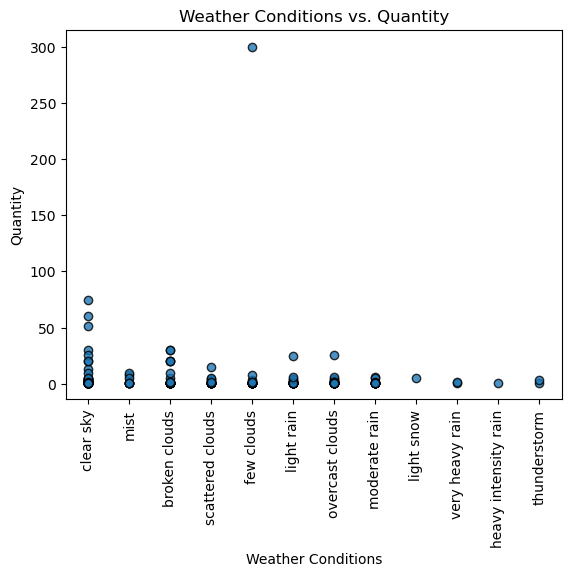

In [11]:
# Building a scatter plots for Product_Category vs. Weather Conditions
plt.scatter(new_sales_data_final['Weather Conditions'], new_sales_data_final['Quantity'], edgecolors="black", marker="o", alpha=0.8)

# Incorporate the other graph properties
plt.title("Weather Conditions vs. Quantity")
plt.xlabel("Weather Conditions")
plt.ylabel("Quantity")
# plt.grid(True)
plt.xticks(rotation=90)

# Save the figure
plt.savefig("output_data_Fig.png")

# Show plot
plt.show()


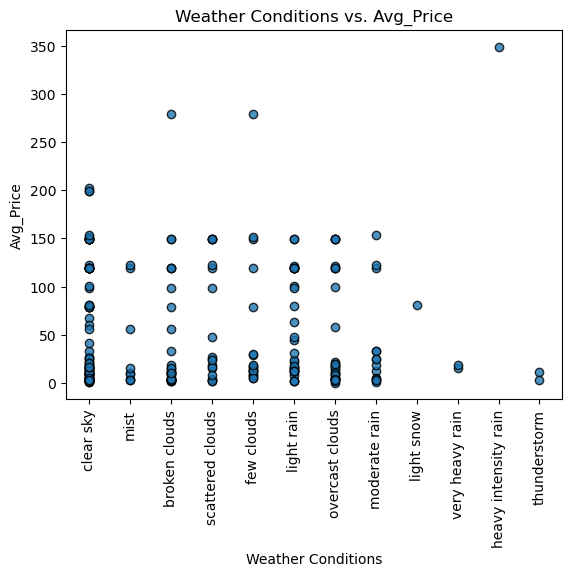

In [13]:
# Building a scatter plots for Product_Category vs. Weather Conditions
plt.scatter(new_sales_data_final['Weather Conditions'], new_sales_data_final['Avg_Price'], edgecolors="black", marker="o", alpha=0.8)

# Incorporate the other graph properties
plt.title("Weather Conditions vs. Avg_Price")
plt.xlabel("Weather Conditions")
plt.ylabel("Avg_Price")
# plt.grid(True)
plt.xticks(rotation=90)

# Save the figure
plt.savefig("output_data_Fig.png")

# Show plot
plt.show()

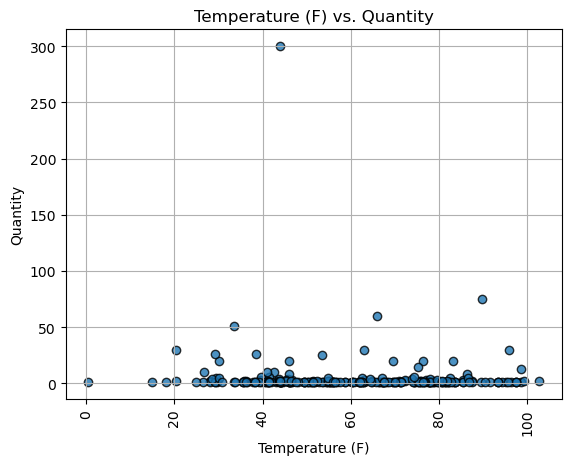

In [14]:
# Building a scatter plots for Quantity vs. Temperature (F)
plt.scatter(new_sales_data_final['Temperature (F)'], new_sales_data_final['Quantity'], edgecolors="black", marker="o", alpha=0.8)

# Incorporate the other graph properties
plt.title("Temperature (F) vs. Quantity")
plt.xlabel("Temperature (F)")
plt.ylabel("Quantity")
plt.grid(True)
plt.xticks(rotation=90)

# Save the figure
plt.savefig("output_data_Fig.png")

# Show plot
plt.show()

###  Temperature (F) vs. Quantity Linear Regression Plots

Slope: -0.055916579885927985
Intercept: 8.031562845944439
R-squared: 0.0029655878743065894
P-value: 0.39124299453773925


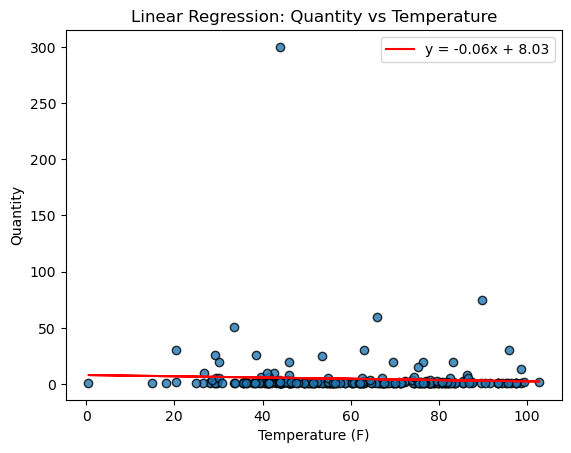

In [15]:
# Linear Regression for Temperature (F) vs Quantity

x_values = new_sales_data_final['Temperature (F)']
y_values = new_sales_data_final['Quantity']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Print regression parameters
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

# Plot the scatter plot 
plt.scatter(x_values, y_values, edgecolors='black', alpha=0.8)

# Plot the regression line
plt.plot(x_values, slope*x_values + intercept, color='red', label=f"y = {slope:.2f}x + {intercept:.2f}")

# Setting graph properties
plt.xlabel('Temperature (F)')
plt.ylabel('Quantity')
plt.title('Linear Regression: Quantity vs Temperature')
plt.legend()
plt.show()

Slope: -0.12690183878382172
Intercept: 59.004983034010564
R-squared: 0.001727922705340174
P-value: 0.5129563093230898


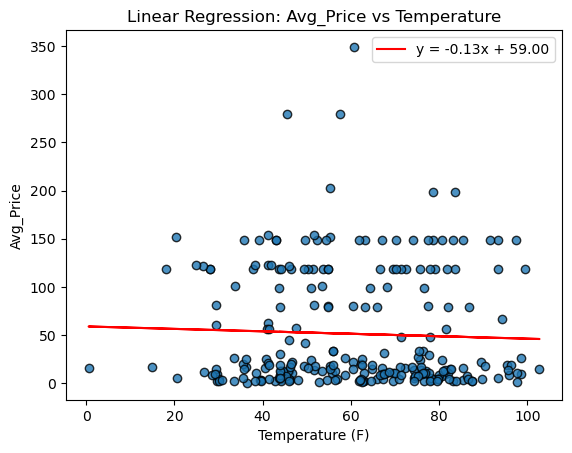

In [16]:
# Linear Regression for Temperature (F) vs Avg_Price

x_values = new_sales_data_final['Temperature (F)']
y_values = new_sales_data_final['Avg_Price']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Print regression parameters
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

# Plot the scatter plot 
plt.scatter(x_values, y_values, edgecolors='black', alpha=0.8)

# Plot the regression line
plt.plot(x_values, slope*x_values + intercept, color='red', label=f"y = {slope:.2f}x + {intercept:.2f}")

# Setting graph properties
plt.xlabel('Temperature (F)')
plt.ylabel('Avg_Price')
plt.title('Linear Regression: Avg_Price vs Temperature')
plt.legend()
plt.show()

/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf 

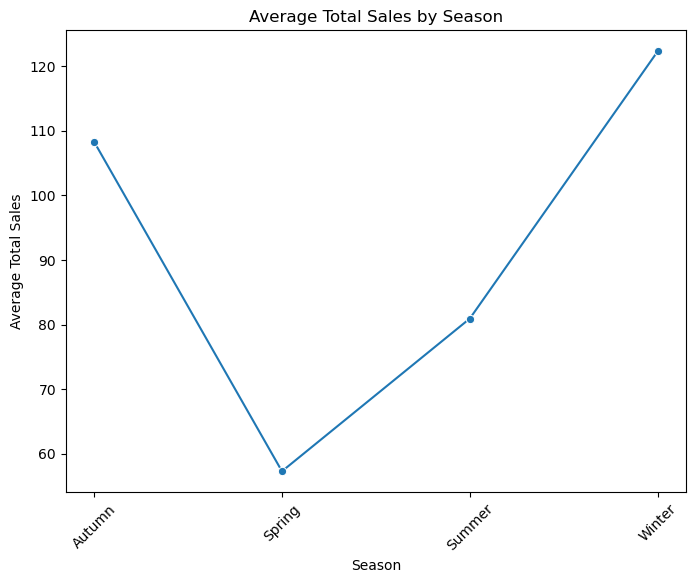

/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


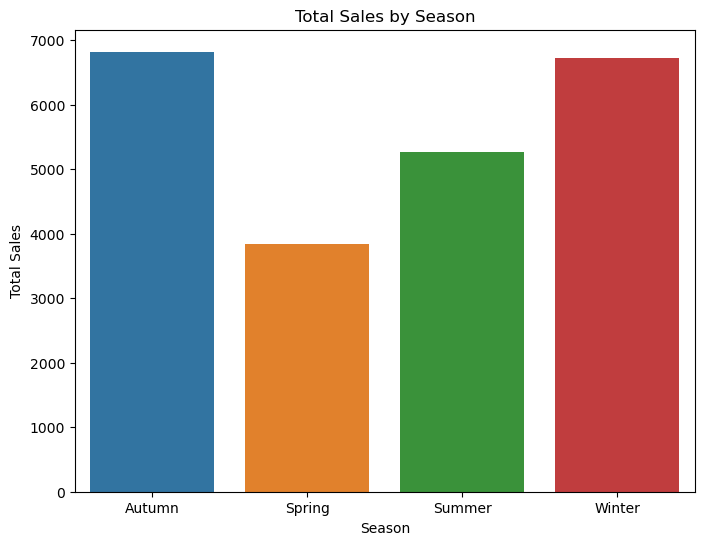

In [9]:
#how does season affect online shopping habits

#Spring: March 1st - May 31st
#Summer: June 1st - August 31st
#Autumn (Fall): September 1st - November 30th
#Winter: December 1st - February 28th


# Convert 'Date' to datetime and create 'Season' column
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:  # months 12, 1, 2
        return 'Winter'

sales_data_final['Date'] = pd.to_datetime(sales_data_final['Date'])
sales_data_final['Season'] = sales_data_final['Date'].dt.month.apply(get_season)

# Calculating Total Sales (Quantity * Avg_Price)
sales_data_final['Total_Sales'] = sales_data_final['Quantity'] * sales_data_final['Avg_Price']

# Aggregating data by season for the line plot
seasonal_sales_line = sales_data_final.groupby('Season').agg({'Total_Sales':'mean'}).reset_index()

# Creating the line plot for seasonal sales
plt.figure(figsize=(8, 6))
sns.lineplot(x='Season', y='Total_Sales', data=seasonal_sales_line, marker='o')
plt.title('Average Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Total Sales')
plt.xticks(rotation=45)
plt.show()

# Aggregating data by season for the bar plot
seasonal_sales_bar = sales_data_final.groupby('Season')['Total_Sales'].sum().reset_index()

# Creating the bar plot for total sales by season
plt.figure(figsize=(8, 6))
sns.barplot(x='Season', y='Total_Sales', data=seasonal_sales_bar)
plt.title('Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.show()

#Emely

/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


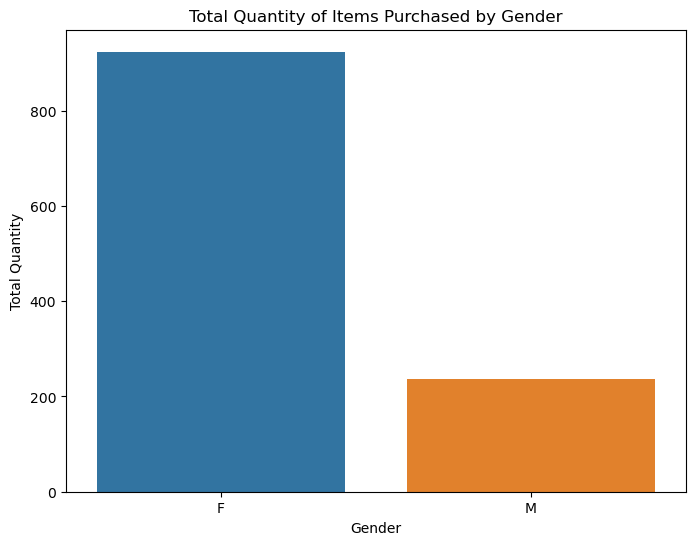

/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

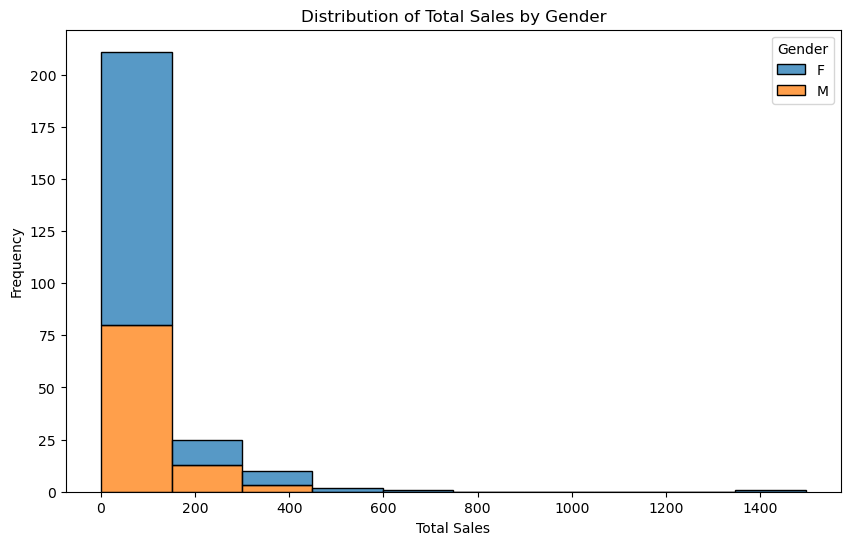

In [10]:
#how does gender impact online shopping habits

# Calculating Total Sales (Quantity * Avg_Price)
sales_data_final['Total_Sales'] = sales_data_final['Quantity'] * sales_data_final['Avg_Price']

# Bar Plot: Total Quantity of Items Purchased by Gender
plt.figure(figsize=(8, 6))
total_quantity_by_gender = sales_data_final.groupby('Gender')['Quantity'].sum().reset_index()
sns.barplot(x='Gender', y='Quantity', data=total_quantity_by_gender)
plt.title('Total Quantity of Items Purchased by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Quantity')
plt.show()

# Histogram: Distribution of Total Sales by Gender
plt.figure(figsize=(10, 6))
sns.histplot(data=sales_data_final, x='Total_Sales', hue='Gender', multiple='stack', bins=10)
plt.title('Distribution of Total Sales by Gender')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()


#Emely

In [11]:
#does the availability of discounts or promotions influence online shopping behavior on online shopping habits  

#rebecca

In [12]:
#are promotions or discounts used more often during inclement weather

#rebecca

In [17]:
#Is there a correlation between the quantity purchased and the occurrence of the most extreme temperatures within a given geographical region?
#Larry

# Define a function to create Linear Regression plots
def linear_regression_plot(x, y, x_label, y_label):
    plt.scatter(x, y, edgecolors='black', alpha=0.8)
    
    # Calculating linear regression statistics
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Plotting the regression line
    plt.plot(x, slope*x + intercept, color='red', label=f"y = {slope:.2f}x + {intercept:.2f}")

    # Setting graph properties
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [18]:
# Creating a DataFrame with the California data
California_sales_data = sales_data_final[sales_data_final['Location'] == 'California']

California_sales_data.head()

,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
CustomerID,,,,,,,,,,,,
14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,89.82,clear sky
14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,55.81,mist
17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,95.90,clear sky
17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,93.34,clear sky
14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,81.27,clear sky


In [19]:
# Creating a DataFrame with the Chicago data
Chicago_sales_data = sales_data_final[sales_data_final['Location'] == 'Chicago']

Chicago_sales_data.head()

,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
CustomerID,,,,,,,,,,,,
12539.0,M,Chicago,35456.0,Collapsible Shopping Bag,Bags,1.0,3.99,12.99,Clicked,2019-08-12,78.64,overcast clouds
16891.0,M,Chicago,19496.0,Nest Cam Indoor Security Camera - USA,Nest-USA,1.0,119.00,6.50,Clicked,2019-02-02,18.09,scattered clouds
17857.0,M,Chicago,25428.0,Nest Cam Indoor Security Camera - USA,Nest-USA,1.0,119.00,6.00,Not Used,2019-04-12,53.62,broken clouds
17218.0,F,Chicago,23119.0,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,2.0,16.99,6.50,Not Used,2019-03-17,36.28,few clouds
12748.0,F,Chicago,25248.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.50,Clicked,2019-04-10,63.10,broken clouds


In [20]:
# Creating a DataFrame with the New Jersey data
New_Jersey_sales_data = sales_data_final[sales_data_final['Location'] == 'New Jersey']

New_Jersey_sales_data.head()

,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
CustomerID,,,,,,,,,,,,
15570.0,F,New Jersey,20890.0,Google Men's Short Sleeve Hero Tee Heather,Apparel,1.0,15.19,6.50,Not Used,2019-02-20,29.32,clear sky
17519.0,F,New Jersey,23097.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,2.0,149.00,6.50,Clicked,2019-03-17,43.05,clear sky
13117.0,M,New Jersey,18594.0,Nest Cam Indoor Security Camera - USA,Nest-USA,1.0,122.77,6.50,Clicked,2019-01-23,24.91,clear sky
17860.0,F,New Jersey,22466.0,26 oz Double Wall Insulated Bottle,Drinkware,1.0,19.99,6.50,Clicked,2019-03-09,35.64,overcast clouds
13869.0,F,New Jersey,31445.0,Google Men's Vintage Badge Tee Black,Apparel,1.0,10.63,12.48,Used,2019-06-28,82.02,clear sky


In [21]:
# Creating a DataFrame with the New York data
New_York_sales_data = sales_data_final[sales_data_final['Location'] == 'New York']

New_York_sales_data.head()

,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
CustomerID,,,,,,,,,,,,
15752.0,F,New York,18082.0,Leatherette Journal,Office,26.0,10.90,6.5,Not Used,2019-01-17,38.52,overcast clouds
17463.0,F,New York,44677.0,Google Crew Sweater Navy,Apparel,1.0,41.59,6.5,Used,2019-11-26,49.59,clear sky
14040.0,F,New York,42869.0,Nest Thermostat E - USA,Nest,1.0,99.00,6.0,Used,2019-11-08,51.04,light rain
16717.0,F,New York,25202.0,Ballpoint Stick Pen 4 Pack,Office,8.0,3.99,6.5,Used,2019-04-10,46.02,mist
17284.0,F,New York,34778.0,Google Men's Long & Lean Tee Charcoal,Apparel,1.0,4.80,6.0,Used,2019-08-05,79.79,overcast clouds


In [22]:
# Creating a DataFrame with the Washington DC data
Washington_DC_sales_data = sales_data_final[sales_data_final['Location'] == 'Washington DC']

Washington_DC_sales_data.head()

,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
CustomerID,,,,,,,,,,,,
15351.0,F,Washington DC,20373.0,Google Twill Cap,Apparel,2.0,8.79,16.65,Used,2019-02-14,43.97,few clouds
17796.0,F,Washington DC,44318.0,Nest Cam Outdoor Security Camera - USA,Nest-USA,1.0,119.00,6.50,Used,2019-11-23,49.33,few clouds
18055.0,F,Washington DC,30445.0,Google Baby Essentials Set,Apparel,1.0,27.19,40.25,Used,2019-06-15,75.22,scattered clouds
12567.0,F,Washington DC,20431.0,Google Canvas Tote Natural/Navy,Bags,1.0,12.79,6.50,Clicked,2019-02-14,43.97,few clouds
14088.0,M,Washington DC,39708.0,Google Laptop and Cell Phone Stickers,Office,2.0,2.39,13.38,Clicked,2019-10-03,87.48,scattered clouds


###  Temperature (F) vs. Quantity per geographical area Linear Regression Plots

The r-value is:0.005162377935746099


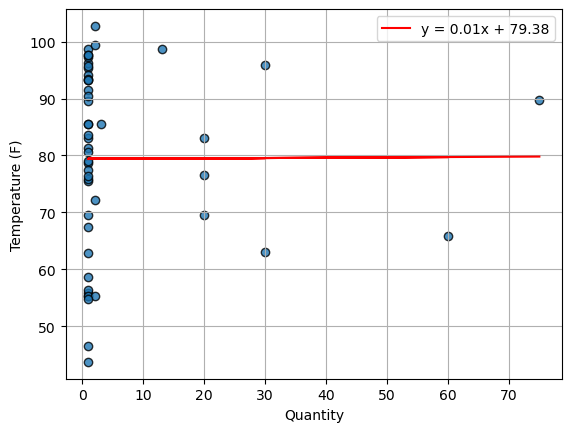

In [23]:
# Creating variables for x, y values
x_values = California_sales_data['Quantity']
y_values = California_sales_data['Temperature (F)']

# Calculating correlation coefficient
r_value = np.corrcoef(x_values, y_values)[0, 1]

# Printing the r-value
print(f"The r-value is:{r_value}")

# Calling Linear Regression Plot function
linear_regression_plot(California_sales_data['Quantity'], California_sales_data['Temperature (F)'],'Quantity', 'Temperature (F)')

The r-value is:-0.208631999264959


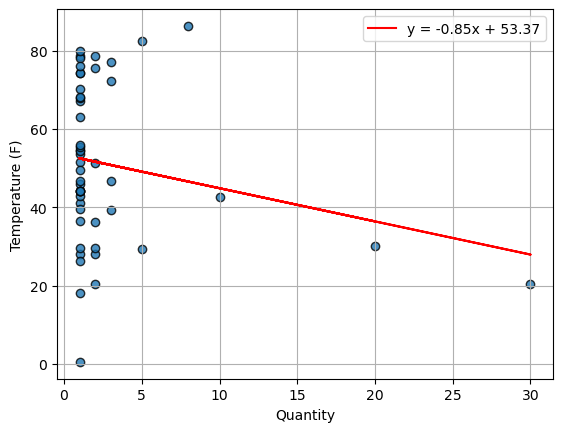

In [24]:
# Creating variables for x, y values
x_values = Chicago_sales_data['Quantity']
y_values = Chicago_sales_data['Temperature (F)']

# Calculating correlation coefficient
r_value = np.corrcoef(x_values, y_values)[0, 1]

# Printing the r-value
print(f"The r-value is:{r_value}")

# Calling Linear Regression Plot function
linear_regression_plot(Chicago_sales_data['Quantity'], Chicago_sales_data['Temperature (F)'],'Quantity', 'Temperature (F)')

The r-value is:-0.20412563892166627


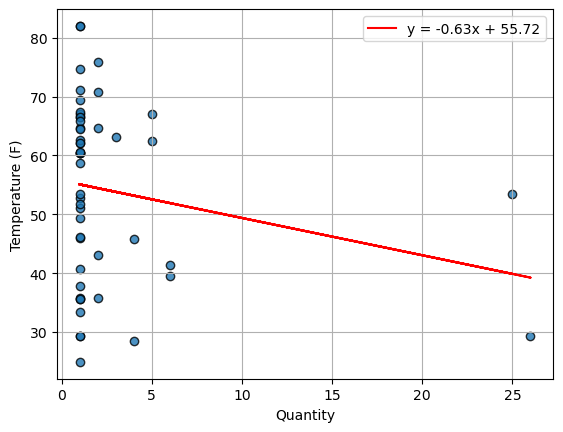

In [25]:
# Creating variables for x, y values
x_values = New_Jersey_sales_data['Quantity']
y_values = New_Jersey_sales_data['Temperature (F)']

# Calculating correlation coefficient
r_value = np.corrcoef(x_values, y_values)[0, 1]

# Printing the r-value
print(f"The r-value is:{r_value}")

# Calling Linear Regression Plot function
linear_regression_plot(New_Jersey_sales_data['Quantity'], New_Jersey_sales_data['Temperature (F)'],'Quantity', 'Temperature (F)')

The r-value is:-0.33291962957305826


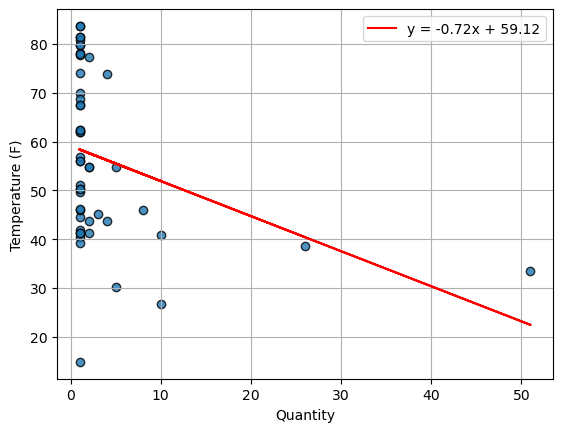

In [26]:
# Creating variables for x, y values
x_values = New_York_sales_data['Quantity']
y_values = New_York_sales_data['Temperature (F)']

# Calculating correlation coefficient
r_value = np.corrcoef(x_values, y_values)[0, 1]

# Printing the r-value
print(f"The r-value is:{r_value}")

# Calling Linear Regression Plot function
linear_regression_plot(New_York_sales_data['Quantity'], New_York_sales_data['Temperature (F)'],'Quantity', 'Temperature (F)')

The r-value is:-0.14179447864580294


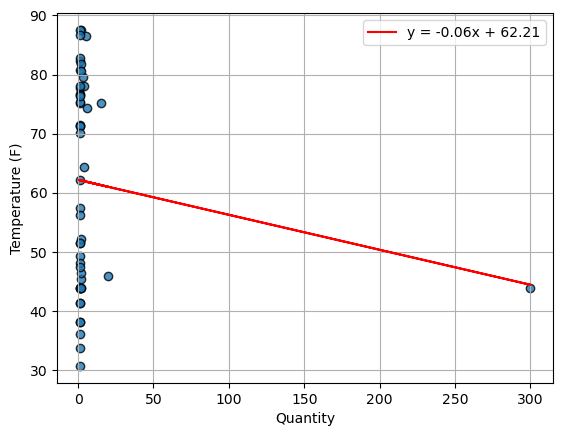

In [27]:
# Creating variables for x, y values
x_values = Washington_DC_sales_data['Quantity']
y_values = Washington_DC_sales_data['Temperature (F)']

# Calculating correlation coefficient
r_value = np.corrcoef(x_values, y_values)[0, 1]

# Printing the r-value
print(f"The r-value is:{r_value}")

# Calling Linear Regression Plot function
linear_regression_plot(Washington_DC_sales_data['Quantity'], Washington_DC_sales_data['Temperature (F)'],'Quantity', 'Temperature (F)')

**Discussion about the linear relationship:** 
Linear relationship between California, Chicago, New Jersey, New York, and Washington DC based on the Temperature (F) vs. Quantity Linear Regression Plots:

California Sales Data: y = 0.01x + 79.38
The slope in this equation is 0.01 and this positive slope indicates a small positive linear relationship between x and y. 
As x increases, y will also increase. The y-intercept is 79.38 and it depicts the value of 
y when x is zero. The magnitude of the slope (0.01) is very small, indicating a weak positive correlation.

Chicago Sales Data: y = −0.85x + 53.37
The slope in this equation is −0.85 and this negative slope indicates a negative linear relationship between 
x and y. As x increases, y is expected to decrease. The y-intercept is 53.37 and it represents the value of y when x is zero. 
The negative slope points to a negative linear relationship. The magnitude of the slope (-0.85) is relatively large, indicating a strong negative correlation.

New Jersey Sales Data: y = −0.63x + 55.72
The slope in this equation is −0.63, and like Chicago, this negative slope indicates a negative linear relationship between 
x and y. As x increases, y will in turn decrease. The y-intercept is 55.72 and it displays the value of y when x is zero. 
The negative slope points to a negative linear relationship. The size of the slope (-0.63) is smaller than the second equation, 
indicating a weaker negative correlation.

New York Sales Data: y = −0.72x + 59.12
The slope in this equation is −0.72, and this negative slope also indicates a negative linear relationship between 
x and y like the second and third equations. As x increases, y is anticipated to decrease. The y-intercept is 59.12 and it displays 
the value of y when x is zero. As stated in the Chicago and New Jersey analysis, the negative slope points to a negative linear relationship. 
The measure of the slope (-0.72) is smaller than the second equation but larger than the third, indicating a moderate negative correlation.

Washington DC Sales Data: y = −0.06x + 62.21
The slope in this equation is −0.06, and this negative slope, lastly, indicates a negative linear relationship between 
x and y. As x increases, y will, as we've mentioned in the previous equations, decrease. The y-intercept is 62.21 and it presents 
the value of y when x is zero. As stated in the previous three analysis', the negative slope points to a negative linear relationship. 
The volume of the slope (-0.06) is the smallest among the given equations, demonstrating a very weak negative correlation.

Correlation coefficient comparison:
The first r-value, 0.005162377935746099, indicates an extremely weak positive correlation. As one variable increases, 
the other tends to increase very weakly, and the correlation is almost nonexistent. 
The last 4 r-values (-0.208631999264959, -0.20412563892166627, -0.33291962957305826, and -0.14179447864580294) are all negative, 
suggesting a negative linear correlation between the two variables(Temperature(F) and Quantity). The fourth equation has the largest 
significance of the r-value, indicating the strongest negative correlation, while the first equation has the smallest measure of the r-value, 
revealing the weakest positive correlation. 

### Using Box Plots to show if there is any correlation between the Temperature (F) and the Quantity per geographical area

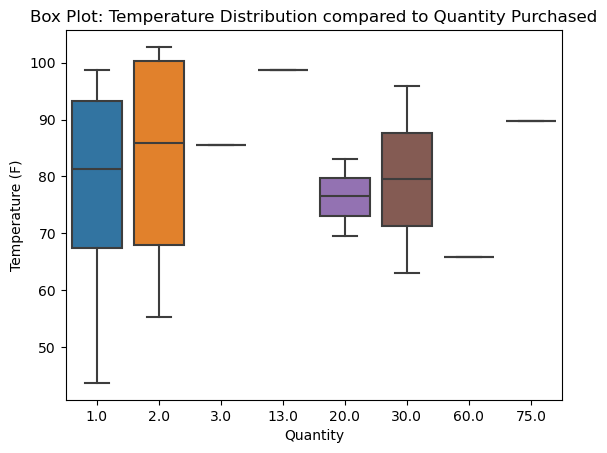

In [28]:
# Box plot for Temperature (F) vs Quantity
sns.boxplot(x='Quantity', y='Temperature (F)', data=California_sales_data)
plt.xlabel('Quantity')
plt.ylabel('Temperature (F)')
plt.title('Box Plot: Temperature Distribution compared to Quantity Purchased')
plt.show()

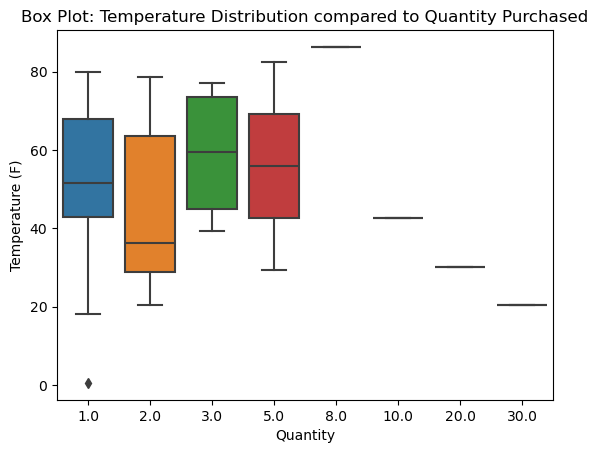

In [29]:
# Box plot for Temperature (F) vs Quantity
sns.boxplot(x='Quantity', y='Temperature (F)', data=Chicago_sales_data)
plt.xlabel('Quantity')
plt.ylabel('Temperature (F)')
plt.title('Box Plot: Temperature Distribution compared to Quantity Purchased')
plt.show()

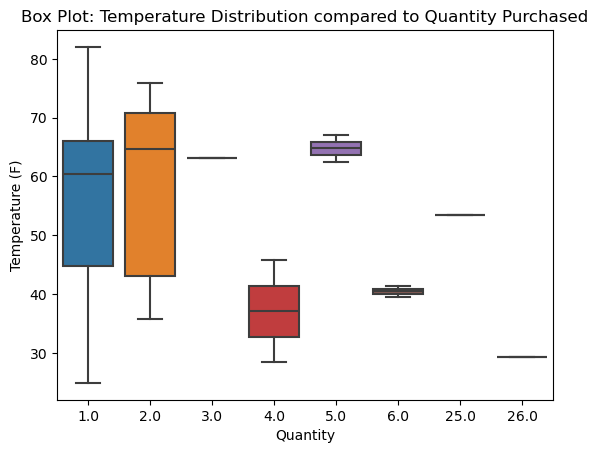

In [30]:
# Box plot for Temperature (F) vs Quantity
sns.boxplot(x='Quantity', y='Temperature (F)', data=New_Jersey_sales_data)
plt.xlabel('Quantity')
plt.ylabel('Temperature (F)')
plt.title('Box Plot: Temperature Distribution compared to Quantity Purchased')
plt.show()

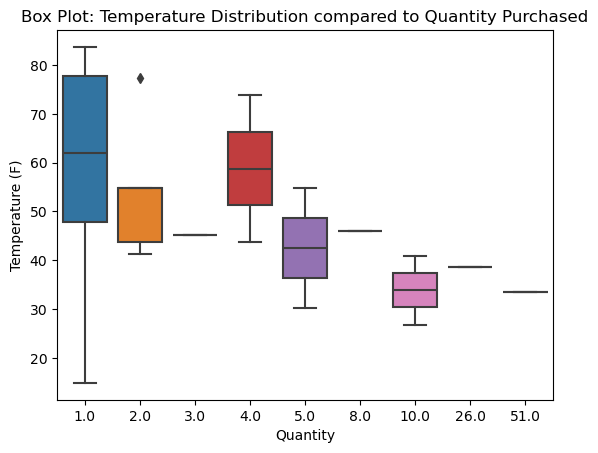

In [31]:
# Box plot for Temperature (F) vs Quantity
sns.boxplot(x='Quantity', y='Temperature (F)', data=New_York_sales_data)
plt.xlabel('Quantity')
plt.ylabel('Temperature (F)')
plt.title('Box Plot: Temperature Distribution compared to Quantity Purchased')
plt.show()

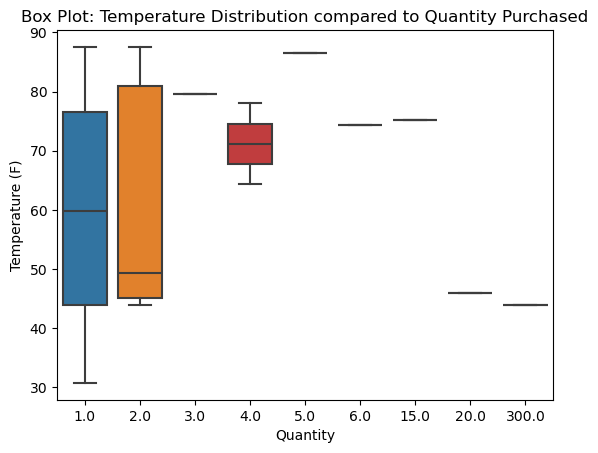

In [32]:
# Box plot for temperature during peak shopping season
sns.boxplot(x='Quantity', y='Temperature (F)', data=Washington_DC_sales_data)
plt.xlabel('Quantity')
plt.ylabel('Temperature (F)')
plt.title('Box Plot: Temperature Distribution compared to Quantity Purchased')
plt.show()

In [14]:
#does the severity of weather influence online shopping behavior?

#Sergio

In [15]:
#is there a correlation between inclement weather and product category?

weather_and_category_df = pd.get_dummies(sales_data_final[['Weather Conditions', 'Product_Category']])

contingency_table = pd.crosstab(sales_data_final['Weather Conditions'], sales_data_final['Product_Category'])

chi2, p, _, _ = stats.chi2_contingency(contingency_table)



print(f"Chi-Squared {chi2}")
print(f"P-Value {p}")


#matt

Chi-Squared 0.0
P-Value 1.0



Null Hypothesis:
There is no relation between weather conditions and the ordering of a specific product category

The p-value is greater than a significance level of 0.05, therefore we reject the null hypothesis.



In [16]:
#descriptive statistics of weather and product category


descriptive_stats = sales_data_final.groupby('Weather Conditions')['Product_Category'].describe()

print(descriptive_stats)




                   count unique      top freq
Weather Conditions                           
                     250     14  Apparel   93


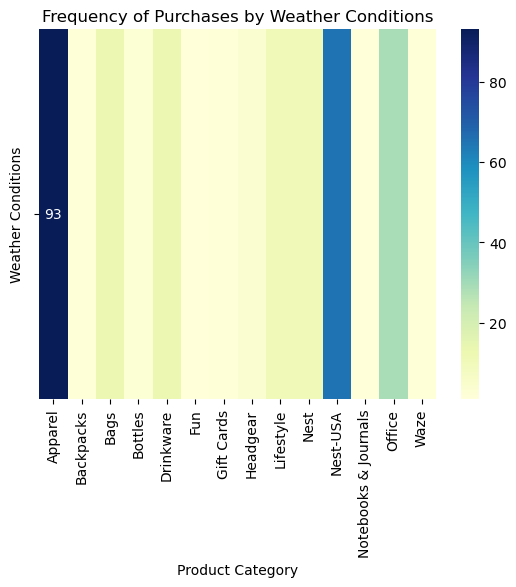

In [17]:
contingency_table = pd.crosstab(sales_data_final['Weather Conditions'], sales_data_final['Product_Category'])
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')

plt.title('Frequency of Purchases by Weather Conditions')
plt.xlabel('Product Category')
plt.ylabel('Weather Conditions')

plt.show()

/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emelyzelaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

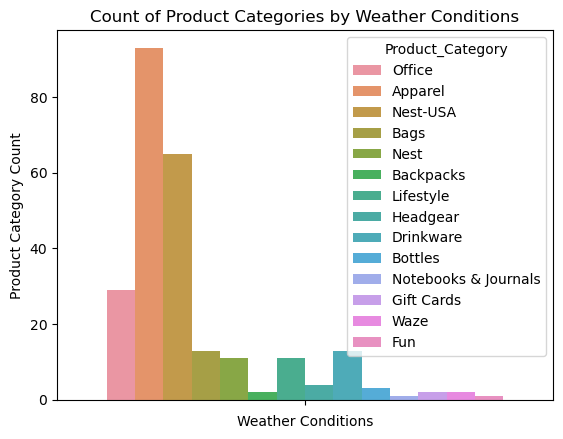

In [18]:
#adding bar chart

sns.countplot(x='Weather Conditions', hue='Product_Category', data=sales_data_final)

plt.xticks(rotation=90)
plt.xlabel('Weather Conditions')
plt.ylabel('Product Category Count')
plt.title('Count of Product Categories by Weather Conditions')

plt.show()

